## <center> Machine Learning from Scratch at ETH Zurich
## <center> 1. Linear Regression with Gradient Descent   &nbsp; &nbsp; &nbsp;    线性回归与梯度下降
### <center> Zhaorui Gong &nbsp; 宫兆瑞

### 1.1 线性回归：普通梯度下降；解析解；sklearn掉包

In [1]:
import numpy as np
import pandas as pd

In [2]:
class LinearRegression:
    def __init__(self, lr = 0.0005, n_iters = 1000, tol = 1e-6, max_iter = 20000):
        self.lr = lr               # the learning rate, eta > 0 
        self.n_iters = n_iters     # the number of iterations 这里没有用梯度下降常规的stopping criterion, 即实际移动距离 < epsilon
        self.coef = None           # the coefficients, beta in stats and w (weights) in machine learning
        self.bias = None           # the intercept
        self.tolerance = tol       # tol 是GD的stopping criterion, 不能太大
        self.max_iter = max_iter   

    def fit(self, X, y):           # X is the n*p design matrix without the first column of 1, y is a n-dim column vector
        n, p = X.shape             # the number samples and the number of features (predictors)
        self.coef = np.zeros(p)    # 最开始先设系数为0向量
        self.bias = 0

        for i in range(0, self.n_iters):
            y_hat = np.dot(X, self.coef) + self.bias
            df_dw = (1 / n) * (X.T @ (y_hat - y))   # 最小二乘对系数求导, GD中的 dL(w^t), d即梯度运算符，倒三角
            df_db = (1 / n) * np.sum(y_hat - y)
    
            self.coef = self.coef - self.lr * df_dw     # GD更新公式：w^(t+1) = w^t - eta * dL(w^t) 
            self.bias = self.bias - self.lr * df_db     # 截距也要更新
            # fit函数不要返回任何东西。它只对attributes做修改。

    def lm(self, X, y):            # 这也是MLR 但其中GD控制距离，而不是指定循环次数
        n, p = X.shape
        self.coef = np.zeros(p)
        self.bias = 0
        distance = self.tolerance * 1000   # 保证第一步肯定能行
        count = 0

        while distance >= self.tolerance and count <= self.max_iter:
            y_hat = np.dot(X, self.coef) + self.bias  # Compute predictions
            df_dw = (1 / n) * np.dot(X.T, (y_hat - y))  # Gradient w.r.t. coefficients
            df_db = (1 / n) * np.sum(y_hat - y)  # Gradient w.r.t. bias
            
            wt = np.r_[self.bias, self.coef]  # Store old parameters
            
            # Gradient descent updates
            self.coef -= self.lr * df_dw
            self.bias -= self.lr * df_db

            wt_1 = np.r_[self.bias, self.coef]  # Store new parameters
            
            
            distance = np.linalg.norm(wt_1 - wt)  # Compute change in parameters
            count += 1

        # for i in range(5):  # Print the first 5 iterations for debugging
        #     print(f"Iteration {i}:")
        #     print("Max Gradient df_dw:", np.max(df_dw))
        #     print("Min Gradient df_dw:", np.min(df_dw))
        #     print("Bias:", self.bias)
        #     print("Coefficients:", self.coef)
        
        
        
    def predict(self, X): 
        y_hat = np.dot(X, self.coef) + self.bias   # 与训练一样
        return y_hat


class LinearRegression_Analytic:     # 解析解：投影矩阵永远的神！注意：矩阵运算因condition number丢失精度，可能导致最终 MSE不如 GD，但差距不应该太大
    def __init__(self):
        self.coef = None
        self.X = None    # the design matrix
        self.residuals = None

    def fit_analytic(self, X, y):
        n, p = X.shape
        self.X = np.c_[np.ones(n), X]
        self.coef = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ y

    def predict(self, X): 
        n, p = X.shape
        y_hat = np.c_[np.ones(n), X] @ self.coef
        return y_hat

    def resid(self, X, y):
        self.residuals = y - X @ self.coef
        return self.residuals
        
        

Next, we test our linear model. We first create a dataset by ourselves, and then define the loss function. Here we use the MSE.

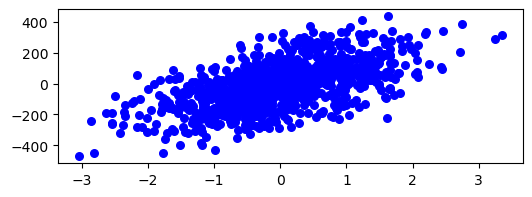

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import datasets   # 自己创造数据集
import matplotlib.pyplot as plt
n_sample = 1000
X, y = datasets.make_regression(n_samples = n_sample, n_features = 5, noise = 20, random_state = 200)   # SLR
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)  # 自动分train test，学着点

fig = plt.figure(figsize = (6,2))
plt.scatter(X[:, 0], y, color = "b", marker = "o", s = 30)
plt.show()   # 看一下生成的数据集

In [4]:
def mse(y_test, y_pred):
    MSE = np.mean((y_pred - y_test)**2)
    return MSE

lm1 = LinearRegression()
lm1.lm(X_train, y_train)     # <- 改这里，实现两种不同的GD方法
y_pred = lm1.predict(X_test)
MSE = mse(y_test, y_pred)
print(f'The MSE using Gradient Descent: {MSE}')

lm2 = LinearRegression_Analytic()
lm2.fit_analytic(X_train, y_train)
y_pred = lm2.predict(X_test)
MSE = mse(y_test, y_pred)
print(f'The MSE using Analytic Solution: {MSE}')

from sklearn import linear_model    # 直接掉包
lm3 = linear_model.LinearRegression()
lm3.fit(X_train, y_train)
y_pred = lm3.predict(X_test)
MSE = mse(y_test, y_pred)
print(f'The MSE using sklearn packages: {MSE}') 


# 以下可视化为了显示Train 和Test两种不同数据点，颜色不一样
# 若 n_features > 1, 则此图像没有意义！！！
# y_pred_line = lm2.predict(X)   # 可以采用任何一种训练方法，改变的只是黑线
# cmap = plt.get_cmap('viridis')
# fig = plt.figure(figsize = (6,4))
# m1 = plt.scatter(X_train, y_train, color = cmap(0.9), s=10)  
# m2 = plt.scatter(X_test, y_test, color = cmap(0.4), s=10)
# plt.plot(X, y_pred_line, color = 'black', linewidth = 0.8, label='Prediction')
# plt.show()

The MSE using Gradient Descent: 462.59604073327534
The MSE using Analytic Solution: 462.60055868832757
The MSE using sklearn packages: 462.6005586883273


Now instead of our created dataset with only 1 feature, we import the dataset of the Project 0 in IML course.

但是注意，由于这个数据集features太多且数值太大，GD会发散。于是，接下来我们用SGD进行优化。

### 1.2 多元线性回归：随机梯度下降

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def mse(y_test, y_pred):
    MSE = np.mean((y_pred - y_test)**2)
    return MSE

class MLR_SGD():
    def __init__(self, lr = 0.001, tolerance = 1e-6, max_iter = 100000, batchsize = int(n_sample/4)):   # batchsize太大太小都不好
        self.lr = lr                                                                                      # 发现：dim越大，需要的batchsize就越大
        self.tol = tolerance
        self.max_iter = max_iter
        self.coef = None
        self.bias = None
        self.loss_history = []  # 用于存储损失
        self.batchsize = batchsize

    def lm_SGD(self, X, y):
        n,p = X.shape
        self.coef = np.zeros(p)
        self.bias = 0
        prev_loss = float('inf')
        count = 0

        for i in range(self.max_iter):
            temp = self.coef
            np.random.seed(201)
            idx = np.random.randint(0, n, 1)   # from 0 to n, pick 1  但是很容易过拟合！！
            Xi = X[idx, :]
            yi = y[idx]
            yi_hat = np.dot(Xi, self.coef) + self.bias

            df_dw = 2/n * Xi * (yi_hat - yi)    # gradient for only 1 point, Xi is 1*p
            df_db = 2/n * (yi_hat - yi)
            self.coef = self.coef - self.lr * df_dw
            self.bias -= self.lr * df_db[0]

            y_hat = np.dot(X, self.coef) + self.bias
            loss = np.mean((y_hat - y) ** 2)   # squared loss, MSE
            self.loss_history.append(loss)
            # if np.linalg.norm(temp - self.coef) < self.tol:
            if abs(loss - prev_loss) < self.tol:
                print(count)
                break
            prev_loss = loss
            count += 1

    def lm_MiniBatchSGD(self, X, y):    # 随机梯度下降的实现：这是真的随机，没有轮着用batch
        n,p = X.shape
        self.coef = np.zeros(p)
        self.bias = 0
        prev_loss = float('inf')
        count = 0

        for i in range(self.max_iter):
            temp = self.coef
            np.random.seed(201)
            idx = np.random.choice(n, self.batchsize, replace = False)   # 无放回，n 取 batchsize个
            if isinstance(X, pd.DataFrame):  # If X is a Pandas DataFrame
                X_batch, y_batch = X.iloc[idx, :], y[idx]
            else:                            # If X is a NumPy array
                X_batch, y_batch = X[idx, :], y[idx]
            
            yb_hat = np.dot(X_batch, self.coef) + self.bias

            df_dw = (2/self.batchsize) * np.dot(X_batch.T, (yb_hat - y_batch))    # gradient for only 1 point, Xi is 1*p
            df_db = (2/self.batchsize) * np.sum((yb_hat - y_batch))
            self.coef = self.coef - self.lr * df_dw
            self.bias -= self.lr * df_db

            y_hat = np.dot(X, self.coef) + self.bias
            loss = np.mean((y_hat - y) ** 2)   # squared loss, MSE
            self.loss_history.append(loss)
            if np.isnan(loss) or np.isinf(loss):   # 防止出现完美拟合，即Project 0 的情况
                print("Loss is NaN or Inf, stopping training.")
                self.coef = None
                break
            # if np.linalg.norm(temp - self.coef) < self.tol:
            if abs(loss - prev_loss) < self.tol:
                print(count)
                break
            prev_loss = loss
            count += 1
        

    def predict(self, X_test):
        if self.coef is None:
            print("The model failed to be trained")
            return None
        return X_test @ self.coef + self.bias

7852
The MSE using Stochastic Gradient Descent: 459.2231963869043


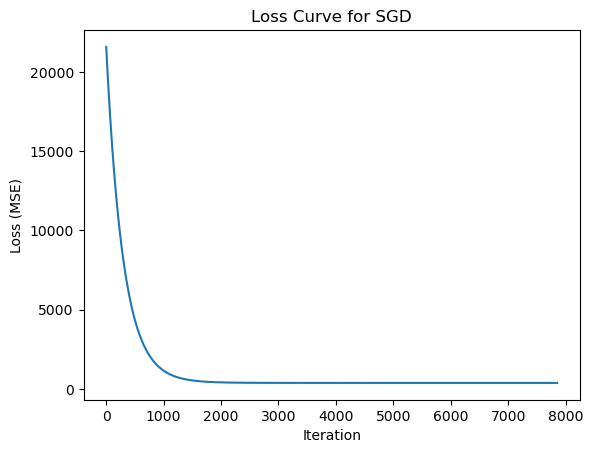

In [6]:
def mse(y_test, y_pred):
    MSE = np.mean((y_pred - y_test)**2)
    return MSE

lm4 = MLR_SGD()
lm4.lm_MiniBatchSGD(X_train, y_train)   # <- Minibatch 收敛。batchsize = 1的SGD可能不收敛。
y_pred = lm4.predict(X_test)            # SGD可能优于以上三种方法（包括掉包），但受dimension和noise level影响严重，不稳定，需多次调试！！！
MSE = mse(y_test, y_pred)
print(f'The MSE using Stochastic Gradient Descent: {MSE}')
plt.plot(lm4.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.title("Loss Curve for SGD")
plt.show()

### 1.3 测试：IML Project 0 数据集，这是一个完美拟合的例子，会导致各种bug

In [7]:
df_train = pd.read_csv(r"C:\Users\reygo\Desktop\宫兆瑞的水壶\ETH硕士课程\Spring 2025\Intro to Machine Learning\IML Project 0\train.csv")
df_test = pd.read_csv(r"C:\Users\reygo\Desktop\宫兆瑞的水壶\ETH硕士课程\Spring 2025\Intro to Machine Learning\IML Project 0\test.csv")

X_train = df_train.iloc[:, 2:]
y_train = df_train.iloc[:, 1]
X_test = df_test.iloc[:, 1:]

# print(X_train.head(3))
# print("Any NaN in X?", np.any(np.isnan(X_train)))    # 用于检测数据集中的空值
# print("Any Inf in X?", np.any(np.isinf(X_train)))
# print("Any NaN in y?", np.any(np.isnan(y_train)))
# print("Any Inf in y?", np.any(np.isinf(y_train)))
# def mse(y_test, y_pred):
#     MSE = np.mean((y_pred - y_test)**2)
#     return MSE

lm5 = LinearRegression_Analytic()
lm5.fit_analytic(X_train, y_train)
print(lm5.coef)      # 这个数据集是完美线性，所以beta0 = 0， 其余都是1
# y_pred = lm5.predict(X_test)

# 注意，SGD 通常用于近似梯度，但你的数据是完美线性可分的，每个 batch 里的数据都是完美一致的，导致：
# 每个 mini-batch 提供的梯度信息没有变化，更新方向几乎相同。
# 梯度几乎恒定，不会有收敛加速的随机性，SGD 反而可能变慢。
lm6 = MLR_SGD(lr = 0.01, tolerance = 0.01, max_iter = 1000)
lm6.lm_MiniBatchSGD(X_train, y_train)
y_pred = lm6.predict(X_test)

# 按照project要求，应当输出pred结果，以交给系统打分。
if y_pred is not None:
    output = pd.DataFrame(
        {"Id": np.arange(10000, 12000),
         "y": y_pred
        })
    output.to_csv("results Zhaorui.csv", index=False)

[1.32438505e-12 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-01 1.00000000e-01 1.00000000e-01]
Loss is NaN or Inf, stopping training.
The model failed to be trained
